# Spongecrystal Topology

**Purpose:** Carefully build and analyze the L∞=1 adjacency graph for the spongecrystal neighborhood.

**Prerequisite:** Run `spongecrystal_survey.ipynb` first to generate the masks and W matrix.

---

## The Surprise

We expected a single connected "crystal" structure. Initial visualization suggests something
much more fragmented—multiple disconnected components, isolated singletons, frozen smoke
rather than frozen crystal.

This notebook carefully examines:
1. How many connected components exist?
2. What's the density/structure of each component?
3. Are the black holes (multi-token vectors) the hubs holding things together?
4. What's actually adjacent to what?

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from safetensors.torch import load_file
from pathlib import Path

# Load saved data from survey notebook
DATA_DIR = Path("../../tensors/Qwen3-4B-Instruct-2507")

W_data = load_file(DATA_DIR / "W_unembed.safetensors")
W_uint16 = W_data['W']  # [151936, 2560] as uint16 (bfloat16 bits)

masks = load_file(DATA_DIR / "masks.safetensors")
black_hole_mask = masks['black_hole_mask']
spongecrystal_mask = masks['spongecrystal_mask']  
neighborhood_mask = masks['neighborhood_mask']

print(f"W shape: {W_uint16.shape}")
print(f"Black hole tokens: {black_hole_mask.sum().item():,}")
print(f"Spongecrystal tokens (L∞ connected): {spongecrystal_mask.sum().item():,}")
print(f"Neighborhood tokens (±5 exp): {neighborhood_mask.sum().item():,}")

W shape: torch.Size([151936, 2560])
Black hole tokens: 2,100
Spongecrystal tokens (L∞ connected): 2,123
Neighborhood tokens (±5 exp): 2,212


In [5]:
# Convert to bfloat16 for lattice coordinate computation
W = W_uint16.view(torch.bfloat16)  # [151936, 2560]

def compute_lattice_coords(W_bf16: torch.Tensor) -> torch.Tensor:
    """
    Convert bfloat16 weights to lattice coordinates.
    Each coordinate = value / ULP, giving integer-like position on bfloat16 lattice.
    """
    bits = W_bf16.view(torch.uint16).to(torch.int32)
    exponent = (bits >> 7) & 0xFF
    effective_exp = torch.where(exponent == 0, torch.ones_like(exponent), exponent)
    ulp = torch.pow(2.0, (effective_exp - 134).float())
    return W_bf16.float() / ulp

def compute_linf_distance(coords_a: torch.Tensor, coords_b: torch.Tensor) -> torch.Tensor:
    """
    Compute pairwise L∞ distance.
    coords_a: [N, D], coords_b: [M, D] -> returns [N, M]
    """
    diff = torch.abs(coords_a.unsqueeze(1) - coords_b.unsqueeze(0))
    return diff.max(dim=2).values

print("Helper functions defined.")

Helper functions defined.


## Step 1: Find Unique Vectors in the Neighborhood

The neighborhood (±5 exponents) contains 2,212 tokens, but many collapse to identical vectors
(the black holes). We need to work with unique vectors for the adjacency graph.

In [6]:
# Get all tokens in the neighborhood
neighborhood_indices = torch.where(neighborhood_mask)[0]
print(f"Neighborhood tokens: {len(neighborhood_indices):,}")

# Get their embeddings - index into bfloat16 W (uint16 indexing not supported)
W_neighborhood = W[neighborhood_indices]  # [2212, 2560] as bfloat16
W_neighborhood_bits = W_neighborhood.view(torch.uint16)

# Find unique vectors (convert to int32 for unique, since uint16 has issues)
unique_bits, inverse_indices, counts = torch.unique(
    W_neighborhood_bits.to(torch.int32), dim=0, 
    return_inverse=True, return_counts=True
)
unique_bits = unique_bits.to(torch.uint16)
n_unique = len(unique_bits)

print(f"Unique vectors: {n_unique}")
print(f"Multi-token vectors (black holes): {(counts > 1).sum().item()}")
print(f"Singletons: {(counts == 1).sum().item()}")

Neighborhood tokens: 2,212
Unique vectors: 125
Multi-token vectors (black holes): 13
Singletons: 112


In [7]:
# For each unique vector, determine:
# 1. How many tokens it contains
# 2. Whether it's in the "core" spongecrystal (flood-fill connected to black holes)
# 3. Whether it IS a black hole (multi-token)

token_counts = counts.numpy()
is_black_hole = (counts > 1).numpy()

# Core membership: check if ANY token mapping to this vector is in spongecrystal_mask
is_core = np.zeros(n_unique, dtype=bool)
for i in range(n_unique):
    # Which neighborhood tokens map to this unique vector?
    token_mask = (inverse_indices == i)
    # Get their original indices
    original_indices = neighborhood_indices[token_mask]
    # Are any in the spongecrystal?
    is_core[i] = spongecrystal_mask[original_indices].any().item()

print(f"Core vectors: {is_core.sum()}")
print(f"Satellite vectors: {(~is_core).sum()}")
print(f"Core black holes: {(is_core & is_black_hole).sum()}")
print(f"Satellite black holes: {(~is_core & is_black_hole).sum()}")

Core vectors: 36
Satellite vectors: 89
Core black holes: 13
Satellite black holes: 0


## Step 2: Compute Pairwise L∞ Distances

With only 125 unique vectors, we can compute the full 125×125 distance matrix easily.

In [8]:
# Convert unique vectors to lattice coordinates
unique_bf16 = unique_bits.view(torch.bfloat16)
lattice_coords = compute_lattice_coords(unique_bf16)  # [n_unique, 2560]

print(f"Lattice coords shape: {lattice_coords.shape}")

# Compute full pairwise L∞ distance matrix
linf_matrix = compute_linf_distance(lattice_coords, lattice_coords)  # [n_unique, n_unique]

print(f"Distance matrix shape: {linf_matrix.shape}")
print(f"Diagonal check (should be 0): {linf_matrix.diag().max():.1f}")

Lattice coords shape: torch.Size([125, 2560])
Distance matrix shape: torch.Size([125, 125])
Diagonal check (should be 0): 0.0


In [9]:
# Distribution of pairwise distances
off_diag_mask = ~torch.eye(n_unique, dtype=torch.bool)
off_diag = linf_matrix[off_diag_mask]

print("L∞ distance distribution (off-diagonal):")
print(f"  Min: {off_diag.min():.1f}")
print(f"  Max: {off_diag.max():.1f}")
print(f"  Median: {off_diag.median():.1f}")
print(f"  Mean: {off_diag.mean():.1f}")

# Count pairs at each small distance
for d in [1, 2, 3, 4, 5]:
    n_pairs = ((off_diag >= d - 0.5) & (off_diag <= d + 0.5)).sum().item() // 2
    print(f"  L∞ = {d}: {n_pairs} pairs")

L∞ distance distribution (off-diagonal):
  Min: 1.0
  Max: 508.0
  Median: 127.0
  Mean: 195.8
  L∞ = 1: 100 pairs
  L∞ = 2: 180 pairs
  L∞ = 3: 100 pairs
  L∞ = 4: 106 pairs
  L∞ = 5: 54 pairs


## Step 3: Build the Adjacency Graph

Criterion: **L∞ = 1** (orthogonally adjacent in lattice space)

In [10]:
# Build networkx graph
G = nx.Graph()

# Add nodes with attributes
for i in range(n_unique):
    G.add_node(i,
               token_count=int(token_counts[i]),
               is_core=bool(is_core[i]),
               is_black_hole=bool(is_black_hole[i]))

# Add edges where L∞ = 1 (within tolerance for floating point)
adjacency = (linf_matrix >= 0.5) & (linf_matrix <= 1.5)
adjacency = adjacency & ~torch.eye(n_unique, dtype=torch.bool)  # No self-loops

edges = torch.where(adjacency)
for i, j in zip(edges[0].tolist(), edges[1].tolist()):
    if i < j:  # Add each edge only once
        G.add_edge(i, j)

print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Graph: 125 nodes, 100 edges


## Step 4: Analyze Connected Components

This is the key question: how fragmented is this structure?

In [11]:
# Find all connected components
components = list(nx.connected_components(G))
components_sorted = sorted(components, key=len, reverse=True)

print(f"Total connected components: {len(components)}")
print(f"Singleton components (isolated nodes): {sum(1 for c in components if len(c) == 1)}")
print(f"Multi-node components: {sum(1 for c in components if len(c) > 1)}")

print("\n" + "="*70)
print("COMPONENT ANALYSIS")
print("="*70)

Total connected components: 96
Singleton components (isolated nodes): 91
Multi-node components: 5

COMPONENT ANALYSIS


In [12]:
# Detailed analysis of each multi-node component
multi_node_components = [c for c in components_sorted if len(c) > 1]

component_stats = []
for i, comp in enumerate(multi_node_components):
    comp_list = list(comp)
    subgraph = G.subgraph(comp_list)
    
    # Basic stats
    n_nodes = len(comp)
    n_edges = subgraph.number_of_edges()
    
    # Token count
    total_tokens = sum(G.nodes[n]['token_count'] for n in comp)
    
    # Core vs satellite
    n_core = sum(1 for n in comp if G.nodes[n]['is_core'])
    n_satellite = n_nodes - n_core
    
    # Black holes
    n_black_holes = sum(1 for n in comp if G.nodes[n]['is_black_hole'])
    
    # Density
    max_edges = n_nodes * (n_nodes - 1) // 2
    density = n_edges / max_edges if max_edges > 0 else 0
    
    # Degree stats
    degrees = [d for n, d in subgraph.degree()]
    
    # Clustering coefficient
    clustering = nx.average_clustering(subgraph)
    
    stats = {
        'component': i + 1,
        'nodes': n_nodes,
        'edges': n_edges,
        'tokens': total_tokens,
        'core': n_core,
        'satellite': n_satellite,
        'black_holes': n_black_holes,
        'density': density,
        'avg_degree': np.mean(degrees),
        'max_degree': max(degrees),
        'clustering': clustering
    }
    component_stats.append(stats)
    
    print(f"\nComponent {i+1}:")
    print(f"  Vectors: {n_nodes} ({n_core} core, {n_satellite} satellite)")
    print(f"  Tokens: {total_tokens:,}")
    print(f"  Black holes: {n_black_holes}")
    print(f"  Edges: {n_edges}")
    print(f"  Density: {density:.3f}")
    print(f"  Avg degree: {np.mean(degrees):.1f}, Max degree: {max(degrees)}")
    print(f"  Clustering: {clustering:.3f}")


Component 1:
  Vectors: 15 (15 core, 0 satellite)
  Tokens: 1,070
  Black holes: 5
  Edges: 66
  Density: 0.629
  Avg degree: 8.8, Max degree: 12
  Clustering: 0.817

Component 2:
  Vectors: 8 (8 core, 0 satellite)
  Tokens: 712
  Black holes: 2
  Edges: 19
  Density: 0.679
  Avg degree: 4.8, Max degree: 6
  Clustering: 0.688

Component 3:
  Vectors: 7 (7 core, 0 satellite)
  Tokens: 312
  Black holes: 1
  Edges: 13
  Density: 0.619
  Avg degree: 3.7, Max degree: 5
  Clustering: 0.790

Component 4:
  Vectors: 2 (0 core, 2 satellite)
  Tokens: 2
  Black holes: 0
  Edges: 1
  Density: 1.000
  Avg degree: 1.0, Max degree: 1
  Clustering: 0.000

Component 5:
  Vectors: 2 (2 core, 0 satellite)
  Tokens: 6
  Black holes: 1
  Edges: 1
  Density: 1.000
  Avg degree: 1.0, Max degree: 1
  Clustering: 0.000


In [13]:
# Summary table
print("\n" + "="*70)
print("SUMMARY TABLE")
print("="*70)
print(f"{'Comp':>4} {'Nodes':>6} {'Tokens':>8} {'Core':>5} {'BH':>4} {'Edges':>6} {'Density':>8} {'Cluster':>8}")
print("-" * 70)

for s in component_stats:
    print(f"{s['component']:>4} {s['nodes']:>6} {s['tokens']:>8,} {s['core']:>5} {s['black_holes']:>4} "
          f"{s['edges']:>6} {s['density']:>8.3f} {s['clustering']:>8.3f}")

# Singletons summary
singletons = [c for c in components if len(c) == 1]
singleton_tokens = sum(G.nodes[list(c)[0]]['token_count'] for c in singletons)
singleton_core = sum(1 for c in singletons if G.nodes[list(c)[0]]['is_core'])
print("-" * 70)
print(f"{'Sing':>4} {len(singletons):>6} {singleton_tokens:>8,} {singleton_core:>5} {'':>4} {'0':>6} {'N/A':>8} {'N/A':>8}")


SUMMARY TABLE
Comp  Nodes   Tokens  Core   BH  Edges  Density  Cluster
----------------------------------------------------------------------
   1     15    1,070    15    5     66    0.629    0.817
   2      8      712     8    2     19    0.679    0.688
   3      7      312     7    1     13    0.619    0.790
   4      2        2     0    0      1    1.000    0.000
   5      2        6     2    1      1    1.000    0.000
----------------------------------------------------------------------
Sing     91      110     4           0      N/A      N/A


## Step 5: Visualize the Structure

Let's see what this actually looks like.

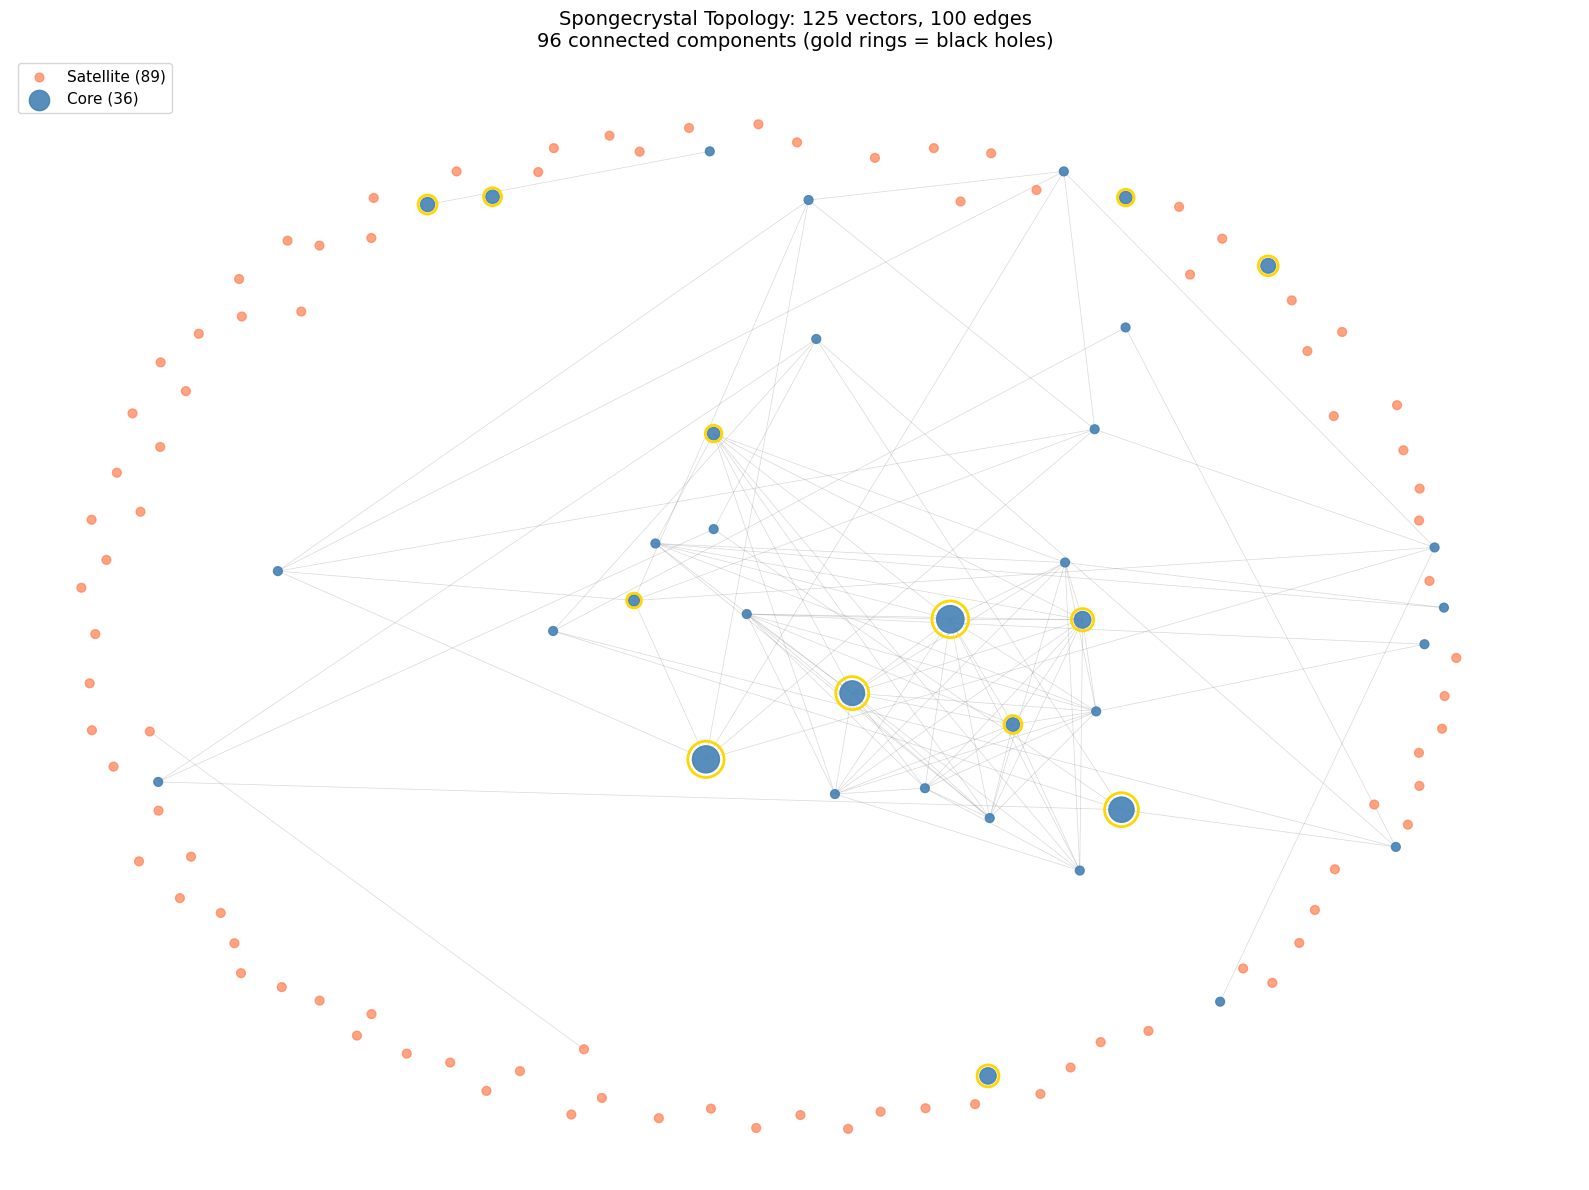


Saved: spongecrystal_topology.png


In [14]:
# Color and size encoding
# - Core = steelblue, Satellite = coral
# - Black holes get gold rings
# - Size proportional to log(token_count)

fig, ax = plt.subplots(figsize=(16, 12))

# Spring layout with seed for reproducibility
pos = nx.spring_layout(G, seed=42, k=2.0, iterations=100)

# Separate node types
core_nodes = [n for n in G.nodes() if G.nodes[n]['is_core']]
satellite_nodes = [n for n in G.nodes() if not G.nodes[n]['is_core']]
black_holes = [n for n in G.nodes() if G.nodes[n]['is_black_hole']]

# Size function
def node_size(n):
    tc = G.nodes[n]['token_count']
    return max(30, 40 * np.log2(tc + 1))

# Draw edges
nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.3, edge_color='gray', width=0.5)

# Draw satellite nodes
nx.draw_networkx_nodes(G, pos, nodelist=satellite_nodes, ax=ax,
                       node_color='coral', 
                       node_size=[node_size(n) for n in satellite_nodes],
                       alpha=0.7, label=f'Satellite ({len(satellite_nodes)})')

# Draw core nodes
nx.draw_networkx_nodes(G, pos, nodelist=core_nodes, ax=ax,
                       node_color='steelblue',
                       node_size=[node_size(n) for n in core_nodes],
                       alpha=0.9, label=f'Core ({len(core_nodes)})')

# Highlight black holes
if black_holes:
    nx.draw_networkx_nodes(G, pos, nodelist=black_holes, ax=ax,
                           node_color='none',
                           node_size=[node_size(n) * 1.8 for n in black_holes],
                           edgecolors='gold', linewidths=2)

ax.set_title(f'Spongecrystal Topology: {G.number_of_nodes()} vectors, {G.number_of_edges()} edges\n'
             f'{len(components)} connected components (gold rings = black holes)',
             fontsize=14)
ax.legend(loc='upper left', fontsize=11)
ax.axis('off')

plt.tight_layout()
plt.savefig('../../notebooks/analysis/spongecrystal_topology.png', dpi=200, 
            bbox_inches='tight', facecolor='white')
plt.show()

print("\nSaved: spongecrystal_topology.png")

## Step 6: Focus on the Largest Components

Let's visualize each major component separately to see their internal structure.

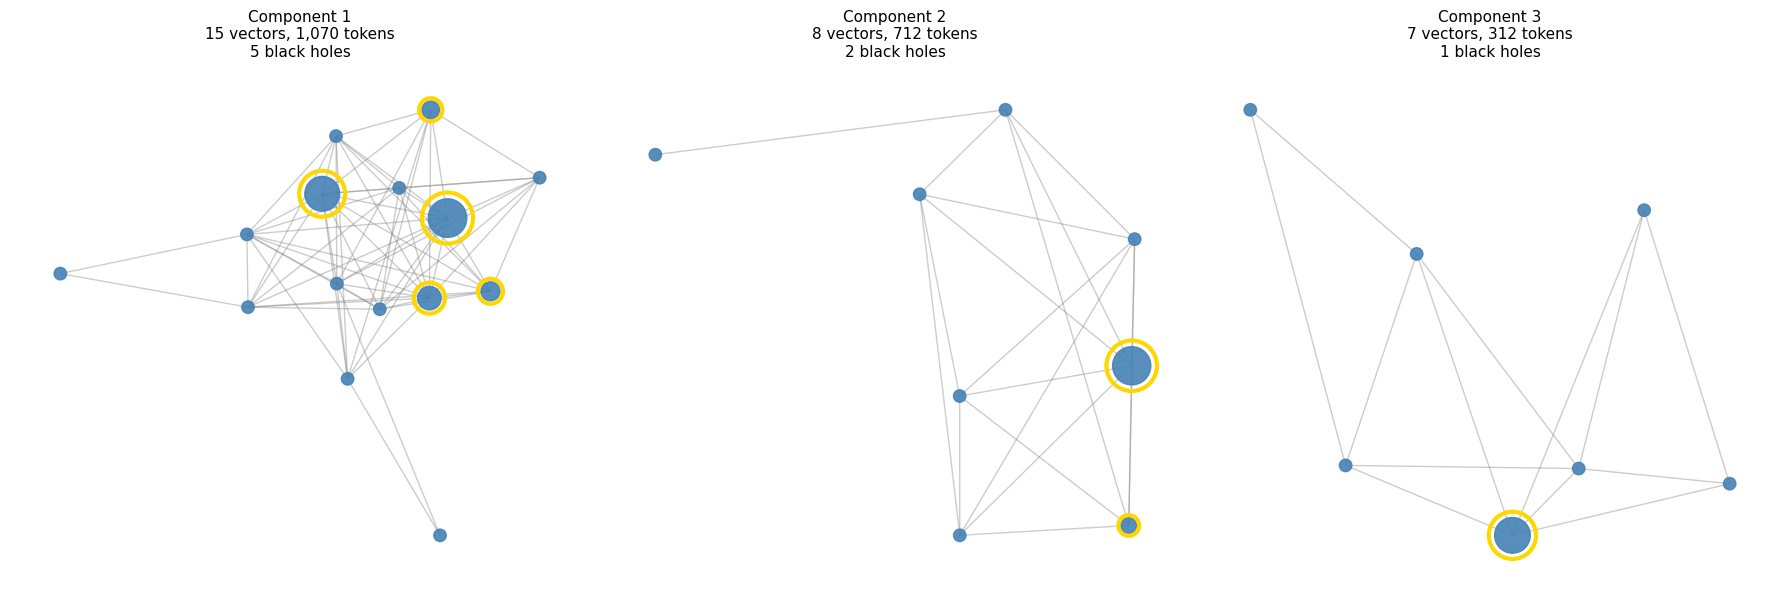


Saved: spongecrystal_components.png


In [15]:
# Plot the top 3 multi-node components side by side
top_components = multi_node_components[:3]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (comp, ax) in enumerate(zip(top_components, axes)):
    comp_list = list(comp)
    subgraph = G.subgraph(comp_list)
    
    # Layout for this component
    comp_pos = nx.spring_layout(subgraph, seed=42, k=1.5, iterations=50)
    
    # Separate by type
    comp_core = [n for n in comp_list if G.nodes[n]['is_core']]
    comp_satellite = [n for n in comp_list if not G.nodes[n]['is_core']]
    comp_bh = [n for n in comp_list if G.nodes[n]['is_black_hole']]
    
    # Draw
    nx.draw_networkx_edges(subgraph, comp_pos, ax=ax, alpha=0.4, edge_color='gray')
    
    if comp_satellite:
        nx.draw_networkx_nodes(subgraph, comp_pos, nodelist=comp_satellite, ax=ax,
                               node_color='coral',
                               node_size=[node_size(n)*2 for n in comp_satellite],
                               alpha=0.7)
    
    if comp_core:
        nx.draw_networkx_nodes(subgraph, comp_pos, nodelist=comp_core, ax=ax,
                               node_color='steelblue',
                               node_size=[node_size(n)*2 for n in comp_core],
                               alpha=0.9)
    
    if comp_bh:
        nx.draw_networkx_nodes(subgraph, comp_pos, nodelist=comp_bh, ax=ax,
                               node_color='none',
                               node_size=[node_size(n)*3.5 for n in comp_bh],
                               edgecolors='gold', linewidths=3)
    
    # Stats
    total_tokens = sum(G.nodes[n]['token_count'] for n in comp)
    n_bh = len(comp_bh)
    
    ax.set_title(f'Component {idx+1}\n{len(comp)} vectors, {total_tokens:,} tokens\n{n_bh} black holes',
                 fontsize=11)
    ax.axis('off')

plt.tight_layout()
plt.savefig('../../notebooks/analysis/spongecrystal_components.png', dpi=200,
            bbox_inches='tight', facecolor='white')
plt.show()

print("\nSaved: spongecrystal_components.png")

## Conclusions

The "spongecrystal" is not a single connected structure. It's more like **frozen smoke**:
- Multiple disconnected components
- Many isolated singletons
- Black holes (multi-token vectors) are scattered across different components

The flood-fill from `spongecrystal_survey.ipynb` found 36 "core" vectors, but this was
misleading—they're reachable from black holes via L∞=1 paths, but they don't form
a single connected graph.